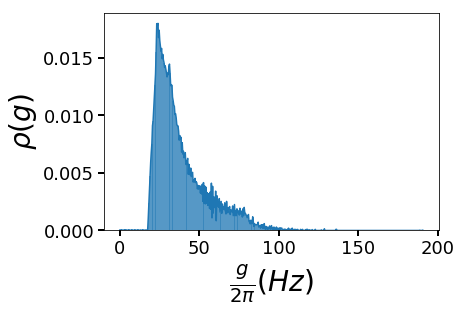

In [1]:
from scipy import constants as sp
import os
import numpy as np
from matplotlib import pyplot as plt
from qsd.data_processing import readcomsol,postproc,setparams

# Read data from downloads
file_dbx = os.getcwd() + '/downloads/exports/Bx_fullData.csv'
file_dby = os.getcwd() + '/downloads/exports/By_fullData.csv'

rdx = readcomsol.ReadComsol(file_dbx)
rdy = readcomsol.ReadComsol(file_dby)

# Read csv file, and get x,y annd dbx/dby data for each
# blocked point in space
bx_x,bx_y,bx_z = rdx.read_full_data()
by_x,by_y,by_z = rdy.read_full_data()

dbx = np.asarray(bx_z).astype(np.float)
dby = np.asarray(by_z).astype(np.float)

# Define geometry of the superconductor
setp = setparams.SetParams()
params = setp.set_params("cpw_parameters.txt")

w = params["w"]
t = params["t"]
l = params["l"]
pen = params["pen"]
omega = params["omega"]
Z = params["Z"]

# Postprocess data
post = postproc.PostProc(w,t,l,pen,omega,Z)

# Single spin coupling for each point on mesh grid
g = post.coupling(dbx,dby,theta=0)

hist, edges = post.spin_density(bx_x,bx_y,g) # density

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(edges,hist,'-')
ax1.bar(edges,height=hist,alpha=0.5)
plt.xlabel('$\\frac{g}{2 \pi} (Hz)$',fontsize=28)
plt.ylabel('$\\rho(g)$',fontsize=28)
ax1.tick_params(direction='out', length=6, width=2, colors='k',labelsize=18)
plt.show()

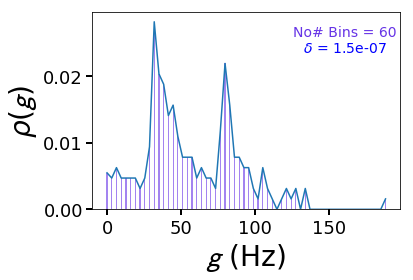

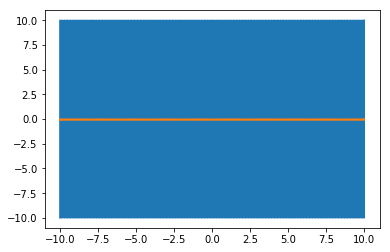

In [14]:
# Define spin map
x = np.asarray(bx_x).astype(float)
y = np.asarray(bx_y).astype(float)
spin_depth = 150e-03 # um
xs = x[(y >= -spin_depth) & (y <= 0.0)]
ys = y[(y >= -spin_depth) & (y <= 0.0)]

dbxs = dbx[(y >= -spin_depth) & (y <= 0.0)]
dbys = dby[(y >= -spin_depth) & (y <= 0.0)]

# Single spin coupling for each point on mesh grid
gs = post.coupling(dbxs,dbys,theta=0)

bin_num = 60

hist_s, edges_s = np.histogram(gs, density=True, bins=bin_num)
edges_s = edges_s[0:len(hist_s)]

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(edges_s,hist_s,'-')
ax1.bar(edges_s,height=hist_s,color=(.4,.2,.9),alpha=0.6)
plt.xlabel('$\\mathcal{g}$ (Hz)',fontsize=28)
plt.ylabel('$\\rho(\\mathcal{g})$',fontsize=28)
plt.text(0.82, 0.9, 'No# Bins = %s'%bin_num, color=(.4,.2,.9), 
         horizontalalignment='center',verticalalignment='center', 
         fontsize=14, transform=ax1.transAxes)
plt.text(0.82, 0.82, '$\delta$ = %s'%str(spin_depth*1e-06), color=(0,0,1), 
         horizontalalignment='center',verticalalignment='center', 
         fontsize=14, transform=ax1.transAxes)
ax1.tick_params(direction='out', length=6, width=2, colors='k',labelsize=18)
plt.tight_layout()
plt.show()
fig.savefig(os.getcwd() + '/figs/g_density_delta.eps')

plt.plot(x,y)
plt.plot(xs,ys)
plt.show()